In [1]:
import pandas as pd
from ide_utils.input_tables import load_dask
from ide_utils.output_table import send_to_output_table

data = load_dask("data").compute().drop('__index_level_0__', axis=1)
data.head()

,Fecha,Linea,Horas,Qty_passangers,uploaded,festivos,window_daily,Mediana,promedio,relacion,dia_semana,window_weekly,Mediana_semanal,promedio_semanal,relacion_semanal
0,2021-01-08,1,05,4915.0,2023-11-16 13:20:23.698531,0,"{'list': [{'item': 614.0}, {'item': 1291.0}, {...",4609.5,3464.055556,1.330666,Friday,"{'list': [{'item': 614.0}, {'item': 4915.0}, {...",5390.0,4681.571429,1.151323
1,2021-01-15,1,05,5201.0,2023-11-16 13:20:23.698531,0,"{'list': [{'item': 4658.0}, {'item': 4745.0}, ...",4915.0,4155.190476,1.182858,Friday,"{'list': [{'item': 614.0}, {'item': 4915.0}, {...",5424.0,4806.000000,1.128589
2,2021-01-22,1,05,5390.0,2023-11-16 13:20:23.698531,0,"{'list': [{'item': 5248.0}, {'item': 5189.0}, ...",5311.0,4562.523810,1.164049,Friday,"{'list': [{'item': 614.0}, {'item': 4915.0}, {...",5458.0,4934.222222,1.106152
3,2021-01-29,1,05,5458.0,2023-11-16 13:20:23.698531,0,"{'list': [{'item': 5311.0}, {'item': 5329.0}, ...",5444.0,4702.238095,1.157747,Friday,"{'list': [{'item': 614.0}, {'item': 4915.0}, {...",5514.5,5048.600000,1.092283
4,2021-02-05,1,05,5571.0,2023-11-16 13:20:23.698531,0,"{'list': [{'item': 5462.0}, {'item': 5547.0}, ...",5547.0,4798.238095,1.156049,Friday,"{'list': [{'item': 614.0}, {'item': 4915.0}, {...",5571.0,5149.454545,1.081862


# Test de normalidad de shapiro-wilk semanal para la afluencia, filtrado por mes y año. 123

In [3]:
import pandas as pd
from scipy.stats import shapiro

def perform_shapiro_normality_test(data, value_column='Qty_passangers'):
    """
    Perform Shapiro-Wilk normality test on weekly data for each month, line, and year.

    :param data: DataFrame containing the data
    :param value_column: The name of the column to test for normality
    :return: Dictionary with test results for each group
    """
    # Extract week and month from 'Fecha'
    data['Week'] = data.index.isocalendar().week
    data['Month'] = data.index.month

    # Group data by 'Linea', 'Year', 'Month', and 'Week'
    grouped_data = data.groupby(['Linea', 'Year', 'Month', 'Week'])

    # Initialize a dictionary for results
    normality_test_results = {}

    # Perform Shapiro-Wilk test for each group
    for group, group_data in grouped_data:
        # Shapiro-Wilk test requires at least 3 data points
        if len(group_data[value_column]) > 3:
            test_statistic, p_value = shapiro(group_data[value_column])
            normality_test_results[group] = (test_statistic, p_value)

    return normality_test_results


# Convert 'Fecha' to datetime and set it as index
data['Fecha'] = pd.to_datetime(data['Fecha'])
data.set_index('Fecha', inplace=True)

# Add the 'Year' column to the dataset
data['Year'] = data.index.year

# Perform the Shapiro-Wilk normality test using the function
normality_test_results_function = perform_shapiro_normality_test(data)
results_df = pd.DataFrame.from_dict(normality_test_results_function, orient='index', columns=['Test Statistic', 'P-Value'])
results_df

,Test Statistic,P-Value
"(1, 2021, 1, 1)",0.945848,7.211329e-05
"(1, 2021, 1, 2)",0.914425,6.871213e-07
"(1, 2021, 1, 3)",0.963836,1.902516e-03
"(1, 2021, 1, 4)",0.959906,8.871098e-04
"(1, 2021, 1, 53)",0.937280,7.189873e-03
...,...,...
"(T-A, 2023, 6, 22)",0.986527,6.397684e-01
"(T-A, 2023, 6, 23)",0.969531,6.053759e-03
"(T-A, 2023, 6, 24)",0.969358,5.839358e-03
"(T-A, 2023, 6, 25)",0.972876,1.229409e-02


# Test de normalidad de lillierfors

In [5]:
import statsmodels.api as sm

def perform_lilliefors_normality_test_annual(data, value_column='Qty_passangers'):
    """
    Perform Lilliefors normality test on annual data for each line.

    :param data: DataFrame containing the data
    :param value_column: The name of the column to test for normality
    :return: DataFrame with test results for each line and year
    """
    # Group data by 'Linea' and 'Year'
    grouped_data = data.groupby(['Linea', 'Year'])

    # Initialize a list for results
    normality_test_results = []

    # Perform Lilliefors test for each group
    for group, group_data in grouped_data:
        # Lilliefors test requires at least 3 data points
        if len(group_data[value_column]) > 3:
            test_statistic, p_value = sm.stats.lilliefors(group_data[value_column], dist='norm')
            normality_test_results.append(group + (test_statistic, p_value))

    # Create a DataFrame from the results
    results_df = pd.DataFrame(normality_test_results, columns=['Linea', 'Year', 'Test Statistic', 'P-Value'])

    return results_df

# Perform the Lilliefors normality test with annual analysis
lilliefors_test_results_annual_df = perform_lilliefors_normality_test_annual(data)
lilliefors_test_results_annual_df.head(30)  # Display the first few rows of the results


,Linea,Year,Test Statistic,P-Value
0,1,2021,0.054983,0.001
1,1,2022,0.089435,0.001
2,1,2023,0.079804,0.001
3,2,2021,0.084050,0.001
4,2,2022,0.069475,0.001
5,2,2023,0.079652,0.001
6,A,2021,0.085108,0.001
7,A,2022,0.103576,0.001
8,A,2023,0.111832,0.001
9,B,2021,0.079010,0.001


# Q-Q Plots

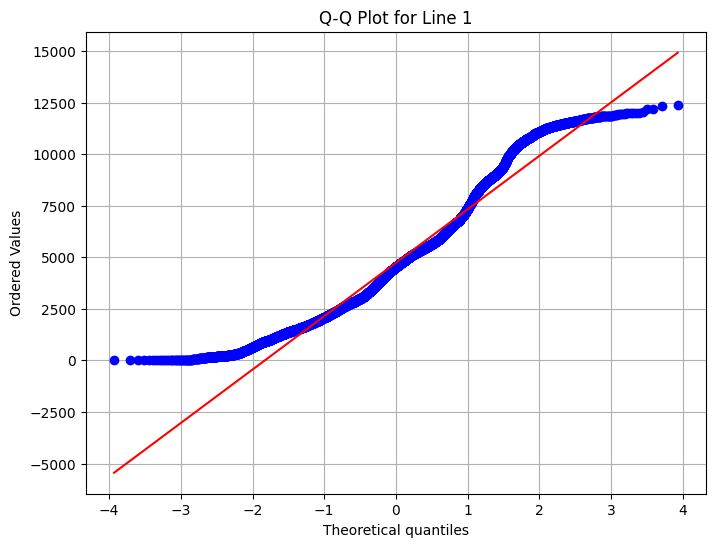

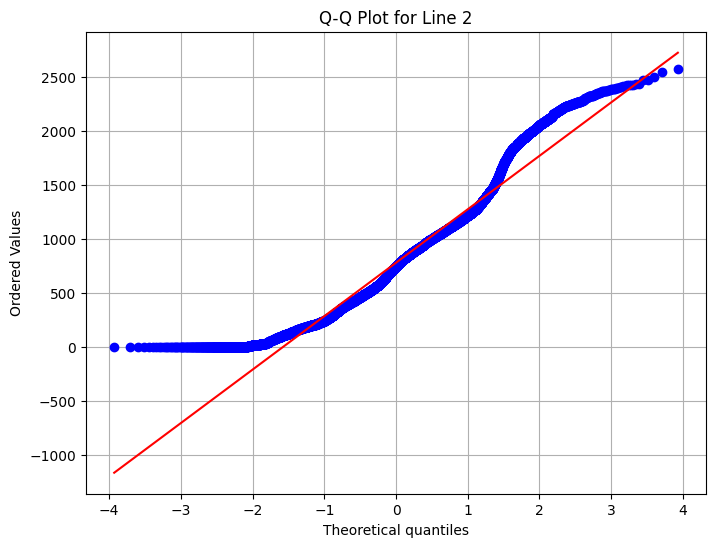

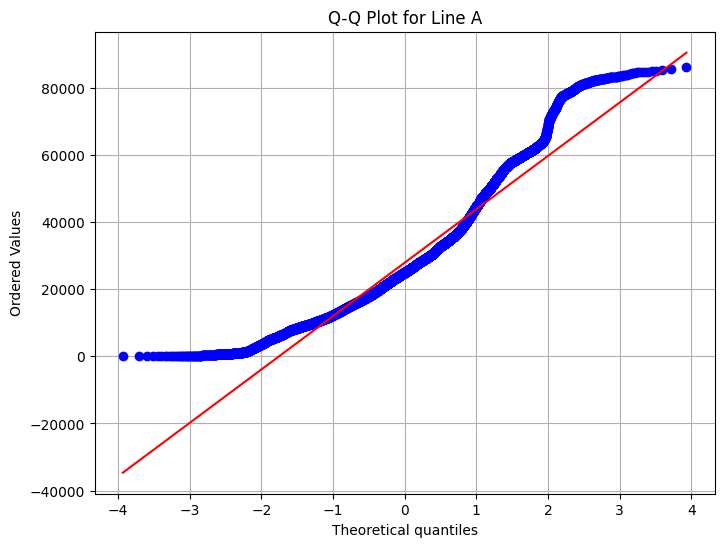

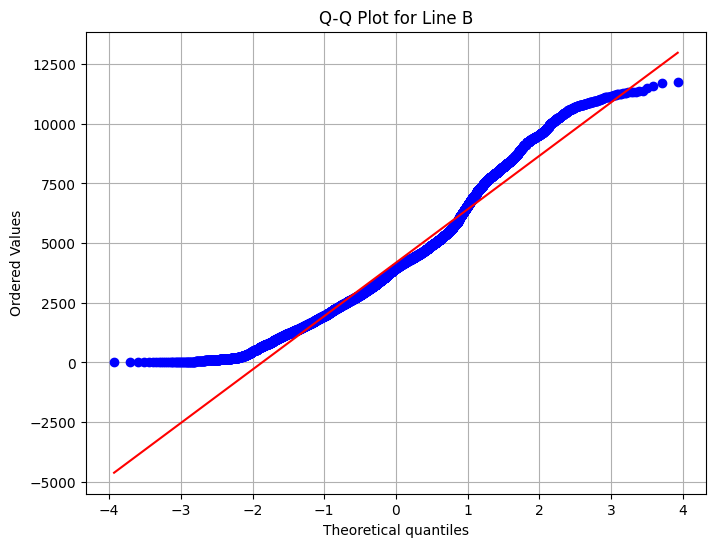

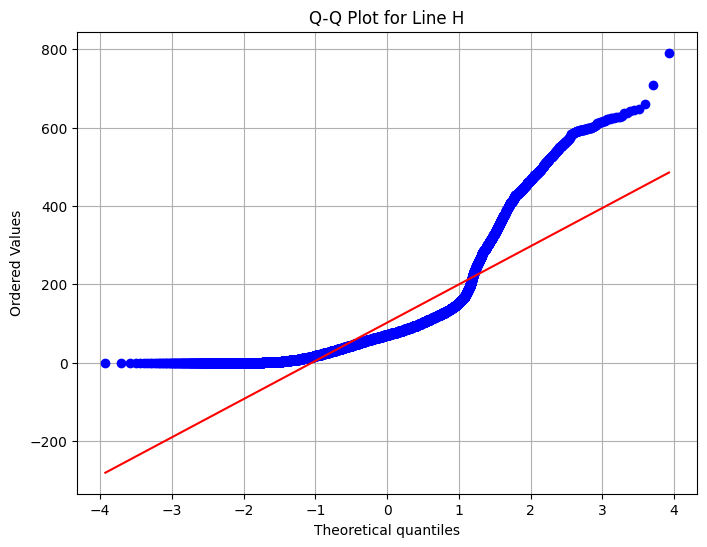

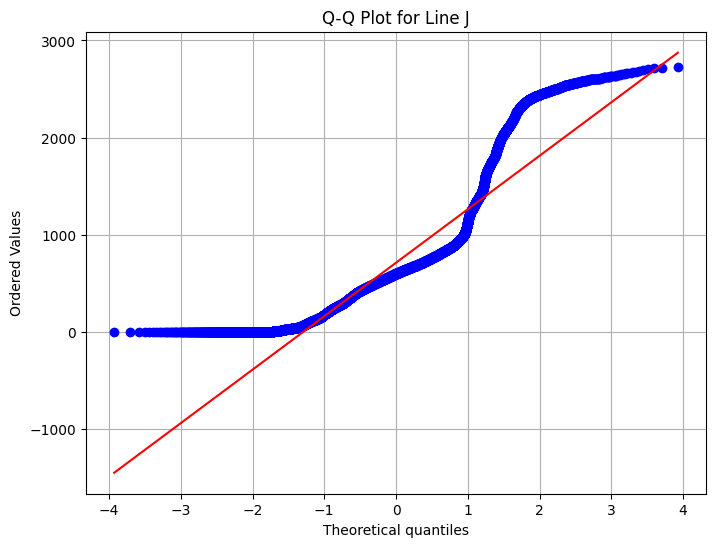

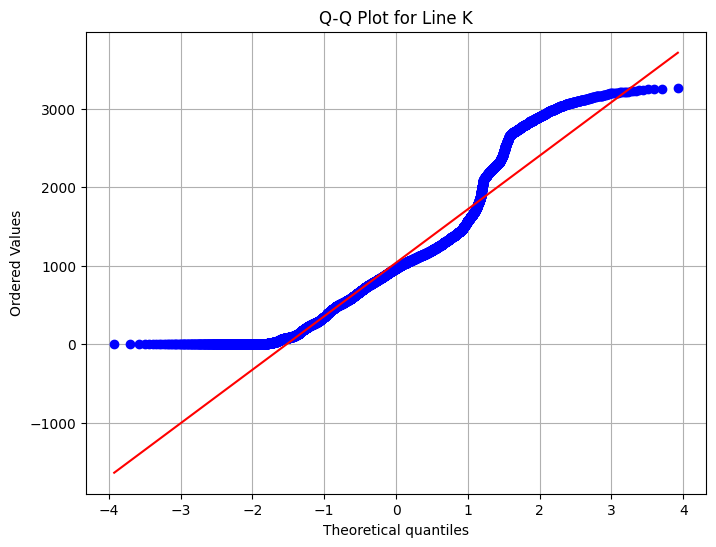

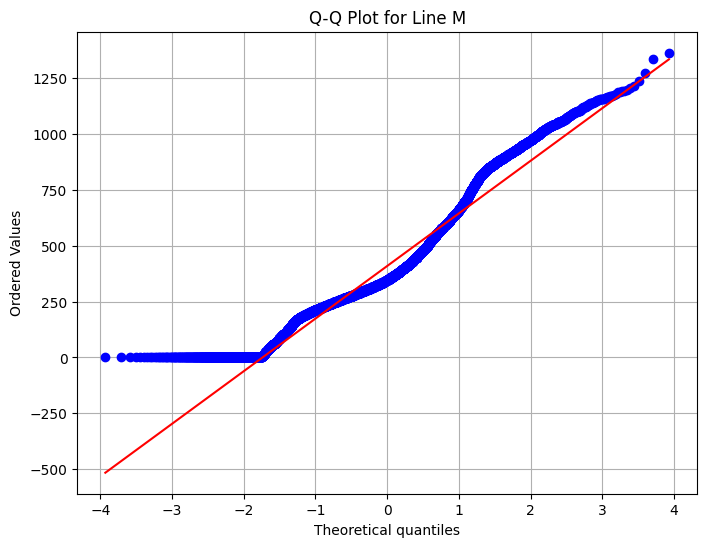

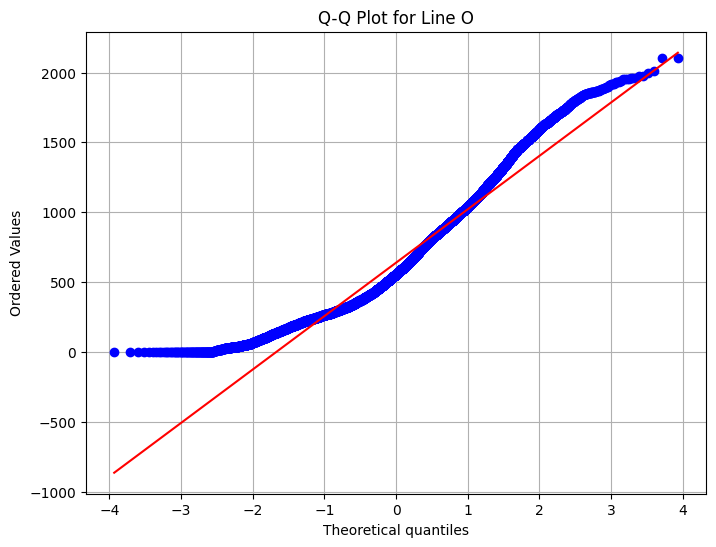

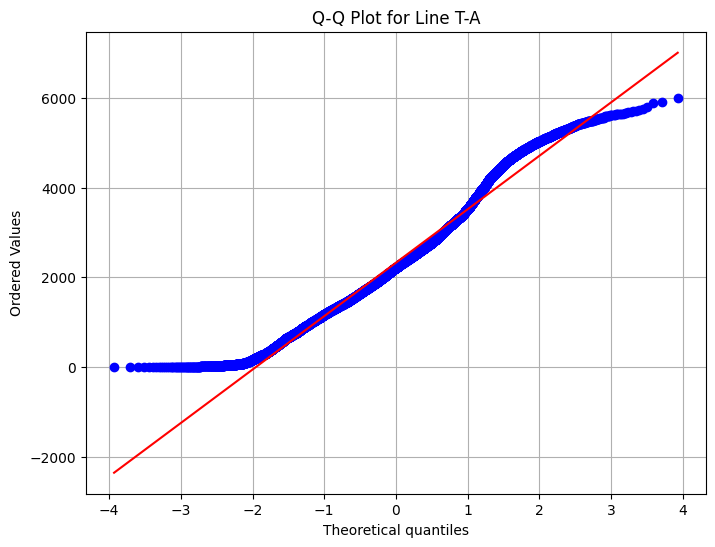

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import probplot

def qq_plots_for_all_lines(data, line_column='Linea', value_column='Qty_passangers'):
    """
    Generate Q-Q plots for the specified value column of each unique line in the DataFrame.

    :param data: DataFrame containing the data.
    :param line_column: The name of the column containing line identifiers.
    :param value_column: The name of the column to create Q-Q plots for.
    """
    # Get unique lines
    lines = data[line_column].unique()
    
    # Create a Q-Q plot for each line
    for line in lines:
        data_line = data[data[line_column] == line][value_column]
        
        fig, ax = plt.subplots(figsize=(8, 6))
        probplot(data_line, dist="norm", plot=ax)
        ax.set_title(f'Q-Q Plot for Line {line}')
        plt.grid()
        plt.show()


full_dataframe = data  
qq_plots_for_all_lines(full_dataframe)  # Llama a la función para generar los gráficos Q-Q para todas las líneas.